In [358]:
import pandas as pd
import torch
import numpy as np
from lightning import pytorch as pl
from chemprop import data, models
import seaborn as sns
from chemprop import data, featurizers, models, nn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import matplotlib.pyplot as plt
import sys
import json
import os
from rdkit import Chem
from chemprop.featurizers.molecule import (
    MorganBinaryFeaturizer,
    MorganCountFeaturizer
)

sys.path.append(os.path.abspath('../lrp_chemprop/'))
from Model_Extractor import model_extractor
from LRP_Explainer import LRP_Explainer
from Data_Preprocessor import Data_Preprocessor
from Faithfulness_Analyzer import Faithfulness_Analyzer
from Correctness_Analyzer import Correctness_Analyzer

# **Import data**

In [473]:
# Read the data, there are only 1 required columns, which is "smiles"
path = 'CDK2/focus_dataset/'
df_total = pd.read_csv(path+'CDK2_focus_data.csv')
split = ''
df_train = df_total[df_total['split'+str(split)]=='train']
df_val = df_total[df_total['split'+str(split)]=='val']
df_test = df_total[df_total['split'+str(split)]=='test'].sort_values('docking_score',ascending=True)

# **Data Preparation**

In [489]:
# Initilized Data_Preprocessor
data_generator = Data_Preprocessor()

# Config
addH = False
HB = True

train_dataset = data_generator.generate(df=df_train,
                              smiles_column='smiles',
                              target_column='docking_score',
                              addH=addH,
                              HB=HB)
train_loader = data.build_dataloader(train_dataset, shuffle=False)


val_dataset = data_generator.generate(df=df_val,
                              smiles_column='smiles',
                              target_column='docking_score',
                              addH=addH,
                              HB= HB)
val_loader = data.build_dataloader(val_dataset, shuffle=False)



test_dataset = data_generator.generate(df=df_test,
                              smiles_column='smiles',
                              target_column='docking_score',
                              addH=addH,
                              HB= HB)
test_loader = data.build_dataloader(test_dataset, batch_size=df_test.shape[0], shuffle=False)
batch = next(iter(test_loader))
bmg, V_d, X_d, Y, *_ = batch

In [376]:
molecule_featurizer = MorganBinaryFeaturizer()
def dataset_generator(df,smiles,y,featurizer=featurizers.SimpleMoleculeMolGraphFeaturizer(), addH = False,keepH=False):
    def datapoint_generator(df,smiles,y,addH=addH):
        smis = df.loc[:,smiles].values
        ys = df.loc[:,[y]].values
        mols = [Chem.MolFromSmiles(smi) for smi in smis]
        x_ds = [molecule_featurizer(mol) for mol in mols]
        datapoints = [data.MoleculeDatapoint.from_smi(smi,y,add_h=addH,keep_h=keepH,x_d=x_d) for smi,y,x_d in zip(smis,ys,x_ds)]

        return datapoints

    datapoints = datapoint_generator(df,smiles,y)

    dataset = data.MoleculeDataset(datapoints, featurizer)
    return dataset

In [377]:
train_dataset = dataset_generator(df_train,'smiles','docking_score',addH=False)
train_loader = data.build_dataloader(train_dataset,seed=2406, shuffle=True)

val_dataset = dataset_generator(df_val,'smiles','docking_score',addH=False)
val_loader = data.build_dataloader(val_dataset,shuffle=False)

test_dataset = dataset_generator(df_test,'smiles','docking_score',addH=False)
test_loader = data.build_dataloader(test_dataset, batch_size=df_test.shape[0], shuffle=False)

# **Model loading**

In [490]:
# Load the model 
model = models.MPNN.load_from_checkpoint(path+'hyperparam_optim_3/best_checkpoint.ckpt')
# Turn off Dropout to interpret model
model.message_passing.dropout.p=0
model.predictor.ffn[1][1].p = 0

/Users/lod/miniconda3/envs/chemprop/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_locatio

In [491]:
# Set up trainer
trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True, 
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=100
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# **Generate Prediction**

In [492]:
# Predict
train_loader = data.build_dataloader(train_dataset,seed=2406, shuffle=False,batch_size=64)
val_loader = data.build_dataloader(val_dataset,seed=2406, shuffle=False,batch_size=64)
test_loader = data.build_dataloader(test_dataset,seed=2406, shuffle=False,batch_size=df_test.shape[0])
with torch.no_grad():
    train_prediction = []
    for batch in train_loader:
        bmg,_,X_d,*_ = batch
        train_prediction.append((model(bmg,X_d=X_d)*model.predictor.output_transform.scale+model.predictor.output_transform.mean).reshape(-1))
    y_train_pred = torch.cat(train_prediction,dim=0)

with torch.no_grad():
    val_prediction = []
    for batch in val_loader:
        bmg,_,X_d,*_ = batch
        val_prediction.append((model(bmg, X_d = X_d)*model.predictor.output_transform.scale+model.predictor.output_transform.mean).reshape(-1))
    y_val_pred = torch.cat(val_prediction,dim=0)


with torch.no_grad():
    test_prediction = []
    for batch in test_loader:
        bmg,_,X_d,*_ = batch
        test_prediction.append((model(bmg,X_d=X_d,V_d=None)*model.predictor.output_transform.scale+model.predictor.output_transform.mean).reshape(-1))
    y_test_pred = torch.cat(test_prediction,dim=0)

In [493]:
y_train_true = train_dataset.Y.reshape(-1)
y_val_true = val_dataset.Y.reshape(-1)
y_test_true = test_dataset.Y.reshape(-1)

y_train_pred = y_train_pred.cpu().numpy()
y_val_pred = y_val_pred.cpu().numpy()
y_test_pred = y_test_pred.cpu().numpy()

# **Store data for uncertainty**

In [ ]:
# Initilized container
train_metrics = {}
val_metrics = {}
test_metrics = {}
for metric in ['RMSE','MAE','R2']:
    for model in range(1,18):
        train_metrics[metric+'_'+str(model)] = []
        val_metrics[metric+'_'+str(model)] = []
        test_metrics[metric+'_'+str(model)] = []

In [495]:
n_bootstrap = 1000
model = 17
for i in range(n_bootstrap):
    # Training set
    indices = np.random.choice(len(y_train_true),len(y_train_true),replace=True)
    y_train_true_bootstrap = y_train_true[indices]
    y_train_pred_bootstrap = y_train_pred[indices]
    rmse = root_mean_squared_error(y_train_true_bootstrap,y_train_pred_bootstrap)
    mae = mean_absolute_error(y_train_true_bootstrap,y_train_pred_bootstrap)
    r2 = r2_score(y_train_true_bootstrap,y_train_pred_bootstrap)
    train_metrics['RMSE_'+str(model)].append(rmse)
    train_metrics['MAE_'+str(model)].append(mae)
    train_metrics['R2_'+str(model)].append(r2)

    # Validation set
    indices = np.random.choice(len(y_val_true),len(y_val_true),replace=True)
    y_val_true_bootstrap = y_val_true[indices]
    y_val_pred_bootstrap = y_val_pred[indices]
    rmse = root_mean_squared_error(y_val_true_bootstrap,y_val_pred_bootstrap)
    mae = mean_absolute_error(y_val_true_bootstrap,y_val_pred_bootstrap)
    r2 = r2_score(y_val_true_bootstrap,y_val_pred_bootstrap)
    val_metrics['RMSE_'+str(model)].append(rmse)
    val_metrics['MAE_'+str(model)].append(mae)
    val_metrics['R2_'+str(model)].append(r2)
    
    # Test set
    indices = np.random.choice(len(y_test_true),len(y_test_true),replace=True)
    y_test_true_bootstrap = y_test_true[indices]
    y_test_pred_bootstrap = y_test_pred[indices]
    rmse = root_mean_squared_error(y_test_true_bootstrap,y_test_pred_bootstrap)
    mae = mean_absolute_error(y_test_true_bootstrap,y_test_pred_bootstrap)
    r2 = r2_score(y_test_true_bootstrap,y_test_pred_bootstrap)
    test_metrics['RMSE_'+str(model)].append(rmse)
    test_metrics['MAE_'+str(model)].append(mae)
    test_metrics['R2_'+str(model)].append(r2)


In [497]:
with open('CDK2/CDK2_train_metrics.json', 'w') as f:
    json.dump(train_metrics, f, indent=4)

with open('CDK2/CDK2_val_metrics.json', 'w') as f:
    json.dump(val_metrics, f, indent=4)

with open('CDK2/CDK2_test_metrics.json', 'w') as f:
    json.dump(test_metrics, f, indent=4)

# **Visualization**

In [542]:
# Open the JSON file
with open('CDK2/CDK2_train_metrics.json', 'r') as file:
    train_metrics = json.load(file)

with open('CDK2/CDK2_val_metrics.json', 'r') as file:
    val_metrics = json.load(file)

with open('CDK2/CDK2_test_metrics.json', 'r') as file:
    test_metrics = json.load(file)

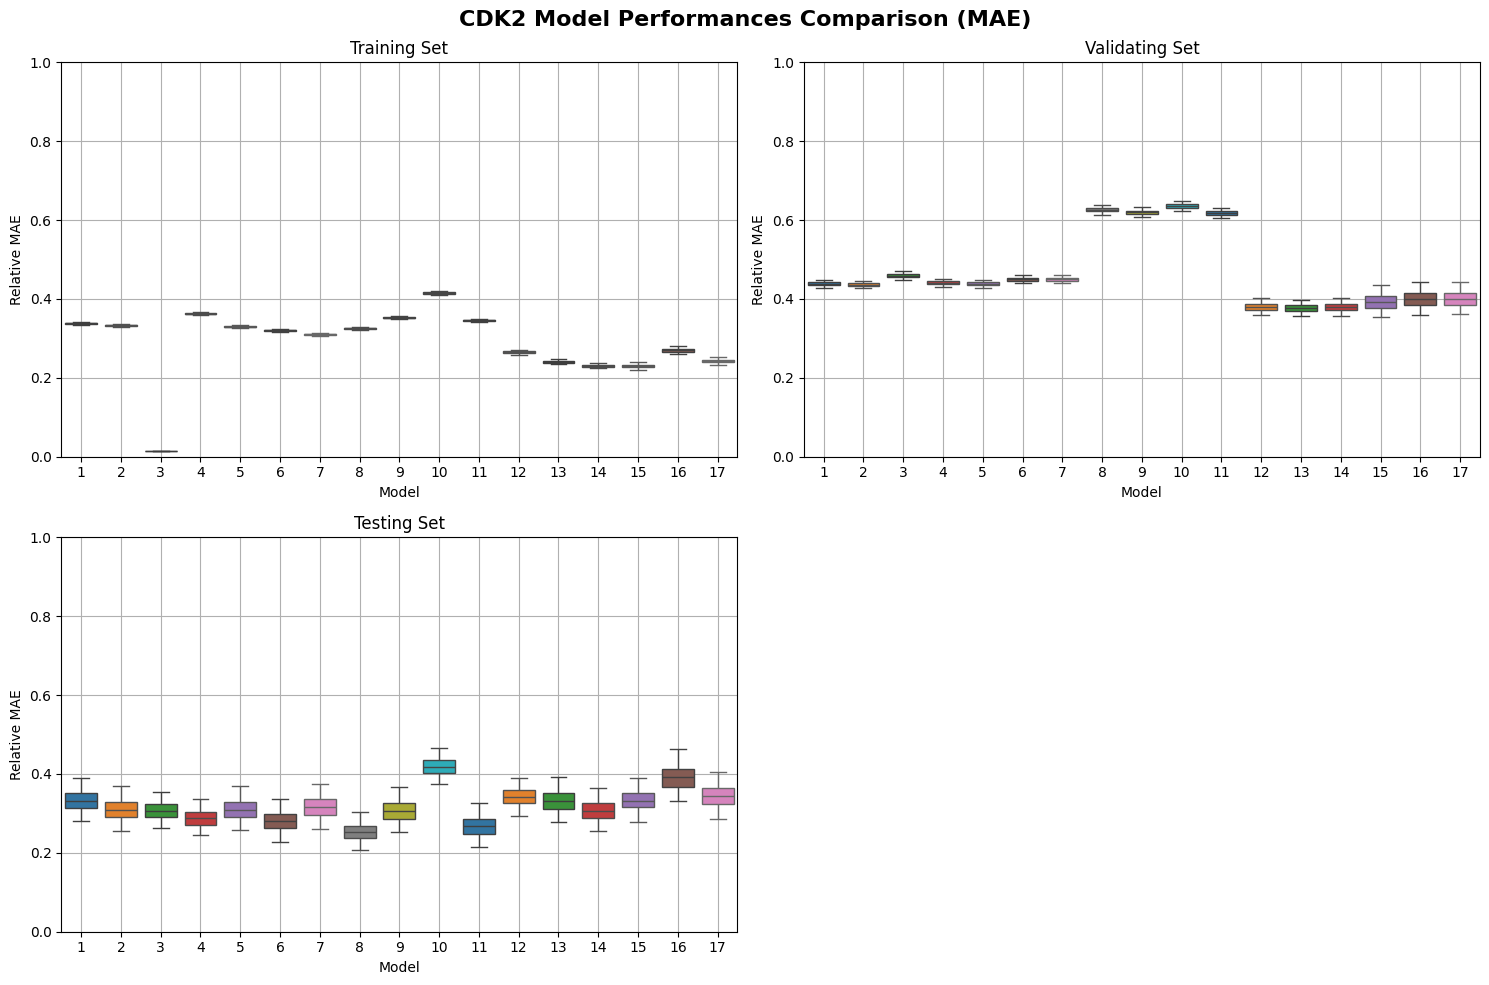

In [ ]:
metric = 'MAE'


fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'CDK2 Model Performances Comparison ({metric})', fontsize=16, fontweight='bold')

for model in range(1, 18):
    # Train
    if model in range(1,8):
        sns.boxplot(x=model, y=np.array(train_metrics[f'{metric}_{model}'])/1.25, ax=axes[0,0],whis=[2.5,97.5],showfliers=False)
    elif model in range(8,12):
        sns.boxplot(x=model, y=np.array(train_metrics[f'{metric}_{model}'])/1.32, ax=axes[0,0],whis=[2.5,97.5],showfliers=False)
    elif model in range(12,15):
        sns.boxplot(x=model, y=np.array(train_metrics[f'{metric}_{model}'])/1.53, ax=axes[0,0],whis=[2.5,97.5],showfliers=False)
    elif model in range(15,18):
        sns.boxplot(x=model, y=np.array(train_metrics[f'{metric}_{model}'])/1.38, ax=axes[0,0],whis=[2.5,97.5],showfliers=False)
    axes[0,0].set_title('Training Set')
    axes[0,0].set_ylim(0, 1)
    axes[0,0].grid()    
    axes[0,0].set_ylabel('Relative ' + metric)
    axes[0,0].set_xlabel('Model')

    # Val
    if model in range(1,8):
        sns.boxplot(x=model, y=np.array(val_metrics[f'{metric}_{model}'])/1.24, ax=axes[0,1],whis=[2.5,97.5],showfliers=False)
    elif model in range(8,12):
        sns.boxplot(x=model, y=np.array(val_metrics[f'{metric}_{model}'])/0.95, ax=axes[0,1],whis=[2.5,97.5],showfliers=False)
    elif model in range(12,15):
        sns.boxplot(x=model, y=np.array(val_metrics[f'{metric}_{model}'])/1.53, ax=axes[0,1],whis=[2.5,97.5],showfliers=False)
    elif model in range(15,18):
        sns.boxplot(x=model, y=np.array(val_metrics[f'{metric}_{model}'])/1.45, ax=axes[0,1],whis=[2.5,97.5],showfliers=False)
    axes[0,1].set_title('Validating Set')
    axes[0,1].set_ylim(0, 1)
    axes[0,1].grid()    
    axes[0,1].set_ylabel('Relative ' + metric)
    axes[0,1].set_xlabel('Model')



    sns.boxplot(x=model, y=np.array(test_metrics[f'{metric}_{model}'])/1.66, ax=axes[1,0],whis=[2.5,97.5],showfliers=False)
    axes[1,0].set_title('Testing Set')
    axes[1,0].set_ylim(0, 1)
    axes[1,0].grid()
    axes[1,0].set_ylabel('Relative ' + metric)
    axes[1,0].set_xlabel('Model')

axes[1,1].axis('off')


# Adjust layout

plt.tight_layout()

plt.show()
